# Select Middle Grade Books on GoodReads

[GoodReads](https://www.goodreads.com/) is a website with tons of book introduction and reviews from users. It is used by many people to share their reading experience. It's also good place to discover books might interesting you.  Recently, my son has moved his reading level from simple chapter books to more complex one. I'd like to find some books with good reviews for my son. So I searched and analyzed middle grade books.  

## Program Overflow

+ First step scrape all middle grade books from [GoodReads](https://www.goodreads.com/search?utf8=%E2%9C%93&query=middle+grade). I use the urllib library to connect to the websites, the BeautifulSoup library to collect all of the HTML, the re library for parsing the words and filtering out other markup based on regular expressions, store book informations in CSV file.  
+ Second step analyze the book informations to reveal good books. Use pandas and matplotlib to manage and plot the final results. 
 

## Part 1. Scrape the data from GoodReads website


+ Enter "middle grade" in [GoodReads](https://www.goodreads.com/search?utf8=%E2%9C%93&query=middle+grade) to search for books in middle grade category
+ See the list of books displayed by the website
+ Access the link to each book's information
+ Scrape all of the html in the book list, it contains multiple pages, each page contain 20 books
+ Extract \['Title', 'Author', 'Ave_rating', 'Rating_cnt', 'Review_cnt', 'Year', 'Pages', 'Publisher'\] from each book's information page and append it to a CSV file for latter use

In [184]:
import urllib
import bs4 
import numpy as np
import pandas as pd
import re
import csv
import matplotlib.pyplot as plt


### Get the first link by searching "middle grade" on goodreads.com

In [171]:
url = "https://www.goodreads.com/search?&query=middle+grade"
source = urllib.request.urlopen(url).read()
soup = bs4.BeautifulSoup(source, 'html.parser')


### Find out the total number of books and get number of pages we need to scrape

In [177]:
#Extract the total number of books in middle-grade shelf
book_num_string = soup.find('h3', class_='searchSubNavContainer').string.rstrip()
print(book_num_string)

book_num = int(book_num_string.split(' ')[4])
print("book number:" + str(book_num))

#Compute the number of pages we need to crawl to get all books
num_per_page = 20
total_pages = int(book_num / num_per_page) + 1
print("Number of web pages: " + str(total_pages))

domain_name = "https://www.goodreads.com"

Page 1 of about 1430 results (0.20 seconds)
book number:1430
Number of web pages: 72


### Extract all book links from one page

In [178]:
def extract_book_link_one_page(page_num):
    """Extract the book links in the page with index page_num"""
    url = "https://www.goodreads.com/search?page=" + str(page_num) + "&q=middle+grade&tab=books"
    print(url)
    
    html_page = urllib.request.urlopen(url).read()
    soup = bs4.BeautifulSoup(html_page, 'html.parser')
    
    #Extract links for books
    links_of_one_page = [domain_name + a.get("href") for a in soup.find_all('a', class_= "bookTitle")]
    return links_of_one_page

links = extract_book_link_one_page(1)
print(len(links))
print(links[0])



https://www.goodreads.com/search?page=1&q=middle+grade&tab=books
20
https://www.goodreads.com/book/show/1609414.Darkness_Falls?from_search=true


In [8]:
print(links[0])

https://www.goodreads.com/book/show/28187.The_Lightning_Thief


Initialize a pandas DataFrame to store books information scraped from webpages

In [93]:
#column_names = ['Title', 'Author', 'Ave_rating', 'Rating_cnt', 'Review_cnt', 'Price', 'Year', 'Pages', 'Publisher']
column_names = ['Title', 'Author', 'Ave_rating', 'Rating_cnt', 'Review_cnt', 'Year', 'Pages', 'Publisher']
books_df = pd.DataFrame(columns=column_names)

### Get book information from the book information webpage for each book

In [409]:
def parse_one_book(book_link):
    """parse one book and store information in pandas object"""
    book_page = urllib.request.urlopen(book_link).read()
    soup = bs4.BeautifulSoup(book_page, 'html.parser')
    
    title = soup.find(id="bookTitle").string.strip()
    author = soup.find('a', class_= "authorName").find('span').string
    ave_rating = soup.find("span", itemprop="ratingValue")
    if ave_rating != None:
        ave_rating = float(ave_rating.string)
    rating_cnt = soup.find("meta", itemprop = "ratingCount")
    if rating_cnt != None:
        rating_cnt = int(rating_cnt.get("content"))
        
    review_cnt = soup.find("meta", itemprop = "reviewCount")
    if review_cnt != None:
        review_cnt = int(review_cnt.get("content"))
    
   # amazon_link = domain_name + soup.find(id="buyButton").get("href")
   # price = get_price_from_amazon(amazon_link)
    
    details = str(soup.find(id="details").find_all("div")[1])
    year = re.findall("\d{3,4}", details)
    if year != None:
        year = year[0]
        
    publisher_line = details.split("\n")[3]
    m = re.search(r"by\s+(.+)", publisher_line);
    if m == None:
        publisher = None
    else:
        publisher = m.group(1)
    
    pages = soup.find("span", itemprop = "numberOfPages")
    if pages != None:
        pages = int(pages.string.split(" ")[0])
    
    book = [title, author, ave_rating, rating_cnt, review_cnt, year, pages, publisher]
    return book
     

parse_one_book(links[0])

['Darkness Falls', 'Les Martin', 3.47, 401, 16, '1996', 108, 'HarperCollins']

### Scrape all books and export the extracted book information into a csv file

For each page, extract all book links on this page.  For each link in one page, extract the book information from it. 

In [410]:
column_names = ['Title', 'Author', 'Ave_rating', 'Rating_cnt', 'Review_cnt', 'Year', 'Pages', 'Publisher']

def scrape_books(total_pages, export_csv_file):
    """Scrape books from all pages"""
    with open(export_csv_file, 'a') as write_obj:
        writer = csv.writer(write_obj)
        writer.writerow(column_names)
    for page_num in np.arange(1, (total_pages + 1)):
        print("Processing page " + str(page_num) + "...")
        with open(export_csv_file, 'a') as write_obj:
            writer = csv.writer(write_obj)
            links_of_one_page = extract_book_link_one_page(page_num)
            print(page_num)
            i = 0
            for link in links_of_one_page:
                book_info = parse_one_book(link)
                i += 1
                if i % 10 == 0:
                    print(i)
                print(book_info)
                writer.writerow(book_info)
            
scrape_books = scrape_books(1, export_csv_file)
export_csv_file = "/Users/hao/code/GoodReadsBooksAnalysis/middle_grade_books.1.csv"

#Caution: uncomment the following lines will begin time consuming we
#export_csv_file = "/Users/hao/code/GoodReadsBooksAnalysis/middle_grade_books.all.csv"
#scrape_books = scrape_books(total_pages, export_csv_file)

Processing page 1...
https://www.goodreads.com/search?page=1&q=middle+grade&tab=books
1
['Darkness Falls', 'Les Martin', 3.47, 401, 16, '1996', 108, 'HarperCollins']
['Squeeze', 'Ellen Steiber', 3.58, 362, 15, '1996', 102, 'Voyager']
['Tiger, Tiger!', 'Les Martin', 3.22, 268, 10, '1995', 112, 'Varrak']
['Humbug', 'Les Martin', 3.41, 248, 7, '1996', 102, 'HarperEntertainment']
['X Marks the Spot', 'Les Martin', 3.57, 497, 29, '1995', 117, 'HarperEntertainment']
['E.B.E.', 'Les Martin', 3.3, 169, 11, '1996', 100, 'HarperEntertainment']
['Fear', 'Les Martin', 3.38, 144, 3, '0064', None, None]
['Voltage', 'Easton Royce', 3.3, 138, 9, '1999', 0, 'Tandem Library']
['Shapes', 'Ellen Steiber', 3.27, 145, 6, '1996', 100, 'HarperTrophy']
10
['Level 6: North and South (Pearson English Graded Readers)', 'Elizabeth Gaskell', 4.13, 127283, 6390, '2016', 120, 'Pearson Education']
['Enter: Ten Tales for Tweens: Fantastic Short Stories for Middle Grade Readers', 'M.J.  Ware', 3.57, 410, 14, '2012', 140

## Part 2.  Analyze the data 

### Read in the book informations from csv file

In [408]:
csv_file = "middle_grade_books.all.csv"
books_df = pd.read_csv(csv_file, header=0)

books_df.head()


,Title,Author,Ave_rating,Rating_cnt,Review_cnt,Year,Pages,Publisher
0,The Lightning Thief,Rick Riordan,4.24,1681546,52524,2006,377.0,Disney Hyperion Books
1,Harry Potter and the Sorcerer's Stone,J.K. Rowling,4.46,5849098,94003,1997,320.0,Scholastic Inc
2,Harry Potter and the Chamber of Secrets,J.K. Rowling,4.41,2267965,43326,1999,341.0,Arthur A. Levine Books / Scholastic Inc.
3,Wonder,R.J. Palacio,4.45,577657,59596,2012,315.0,Alfred A. Knopf
4,The Sea of Monsters,Rick Riordan,4.24,633376,23028,2006,279.0,Hyperion Books


### Survey the data

In [275]:
print(books_df.describe())
books_df.dtypes

        Ave_rating    Rating_cnt     Review_cnt         Year        Pages
count  1247.000000  1.247000e+03    1247.000000  1247.000000  1233.000000
mean      4.041796  8.519112e+04    3141.408982  2011.484362   289.655312
std       0.209771  3.512931e+05    8772.599046    42.612964   169.125838
min       3.250000  1.400000e+01      16.000000  1898.000000     0.000000
25%       3.900000  3.472500e+03     508.000000  2006.000000   216.000000
50%       4.030000  1.202000e+04    1016.000000  2011.000000   273.000000
75%       4.180000  4.072850e+04    2413.000000  2015.000000   342.000000
max       4.740000  5.849098e+06  162099.000000  3372.000000  4100.000000


Title          object
Author         object
Ave_rating    float64
Rating_cnt      int64
Review_cnt      int64
Year            int64
Pages         float64
Publisher      object
dtype: object

### Draw the histogram of rating score

Text(0.5, 1.0, 'Histogram of Ratings of Middle Grade Books')

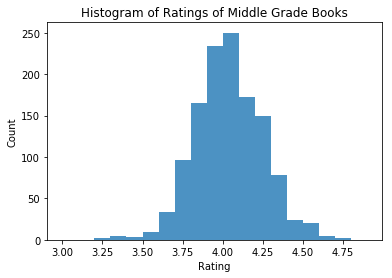

In [276]:
plt.hist(books_df["Ave_rating"], bins=np.arange(3,5,0.1), alpha = 0.8)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Histogram of Ratings of Middle Grade Books")

Find books whose rating is greater than 4.5.

In [277]:
books_df[books_df["Ave_rating"] >= 4.5]

,Title,Author,Ave_rating,Rating_cnt,Review_cnt,Year,Pages,Publisher
5,Harry Potter and the Prisoner of Azkaban,J.K. Rowling,4.55,2316208,45509,2004,435.0,Scholastic Inc.
8,The Last Olympian,Rick Riordan,4.51,569812,20025,2009,381.0,Disney-Hyperion Books
11,Harry Potter and the Goblet of Fire,J.K. Rowling,4.55,2168131,38251,2002,734.0,Scholastic
15,Harry Potter and the Deathly Hallows,J.K. Rowling,4.63,2202522,58728,2007,759.0,Arthur A. Levine Books / Scholastic Inc.
16,Harry Potter and the Half-Blood Prince,J.K. Rowling,4.56,2070718,33240,2006,652.0,Scholastic Inc.
46,The House of Hades,Rick Riordan,4.55,215164,13216,2013,597.0,Disney-Hyperion Books
172,The War I Finally Won,Kimberly Brubaker Bradley,4.52,12704,2162,2017,387.0,Dial Books
202,Refugee,Alan Gratz,4.52,17429,3633,2017,352.0,Scholastic
247,Wundersmith: The Calling of Morrigan Crow,Jessica Townsend,4.55,5527,1063,2018,467.0,Lothian Children's Books (Hachette Australia)
302,Percy Jackson's Greek Gods,Rick Riordan,4.50,40754,3215,2014,417.0,Disney Hyperion


### Draw the distribution of rating count.

Text(0.5, 1.0, 'Histogram of Count of Ratings of Middle Grade Books')

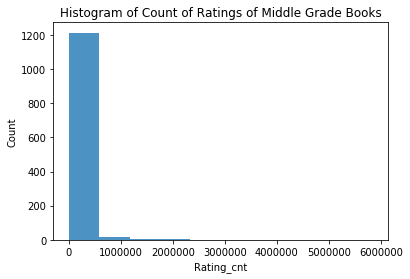

In [278]:
plt.hist(books_df["Rating_cnt"], alpha = 0.8)
plt.xlabel("Rating_cnt")
plt.ylabel("Count")
plt.title("Histogram of Count of Ratings of Middle Grade Books")

We can see dominant amount of rating count around 0-500000.  Check whether there is data missing.  Check Whether there is some abnormal number of rating count.

In [279]:
min(books_df["Rating_cnt"])

14

Let's see which book contains the most number of ratings?

In [280]:
books_df[books_df["Rating_cnt"] == np.max(books_df["Rating_cnt"])]

,Title,Author,Ave_rating,Rating_cnt,Review_cnt,Year,Pages,Publisher
1,Harry Potter and the Sorcerer's Stone,J.K. Rowling,4.46,5849098,94003,1997,320.0,Scholastic Inc


Let's take a closer look into those rating count greater than 1000000.

Text(0.5, 1.0, 'Histogram of Count of Ratings less than 10e+6')

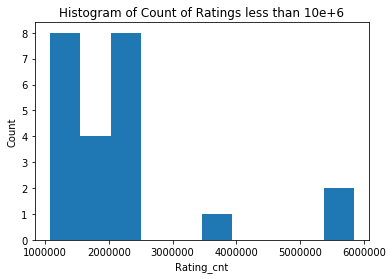

In [281]:
tmp_df = books_df.loc[books_df["Rating_cnt"] > 1000000]

plt.hist(tmp_df["Rating_cnt"])
plt.xlabel("Rating_cnt")
plt.ylabel("Count")
plt.title("Histogram of Count of Ratings less than 10e+6")

In [285]:
books_df[(books_df["Rating_cnt"] > 3000000) & (books_df["Rating_cnt"] < 4000000)]

,Title,Author,Ave_rating,Rating_cnt,Review_cnt,Year,Pages,Publisher
1003,To Kill a Mockingbird,Harper Lee,4.27,3877888,82291,2006,324.0,NaN


## Is rating count correlated to review count?

Text(0.5, 1.0, 'Relation between Rating Count and Review Count')

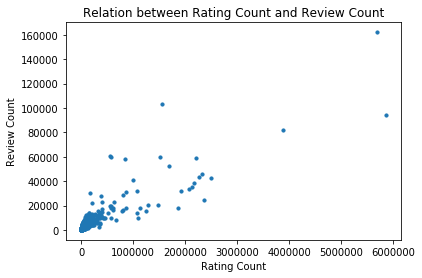

In [286]:
plt.scatter(books_df["Rating_cnt"], books_df["Review_cnt"], s= 10)
plt.xlabel("Rating Count")
plt.ylabel("Review Count")
plt.title("Relation between Rating Count and Review Count")

#Remove the outlier
#plt.xlim(0, 2500000)
#plt.ylim(0, 70000)


Are Rating count and Review count related to each other?

In [287]:
from scipy.stats.stats import pearsonr 
print(pearsonr(books_df["Rating_cnt"], books_df["Review_cnt"]))

#Remove the "outlier"
data = books_df.loc[books_df["Rating_cnt"] < 5000000]
print(pearsonr(data["Rating_cnt"], data["Review_cnt"]))

(0.8771907967391017, 0.0)
(0.8286520052048375, 1.60826915e-315)


### Does Rating count and Review count be fit in linear regression?

(1245, 1)
(933, 1)
Coefficients: 
 [[0.02268694]]
Mean squared error: 11697654.89
Variance score: 0.75


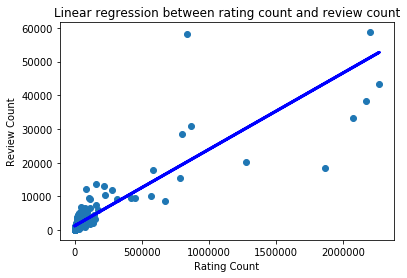

In [288]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

data = books_df[books_df["Rating_cnt"] < 5000000]
X = data["Rating_cnt"].values.reshape(-1, 1)
y = data["Review_cnt"].values.reshape(-1, 1)
print(X.shape)

#Split the data set into training part and testing part
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)
print(train_X.shape)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(train_X, train_y)

# Make predictions using the testing set
pred_y = regr.predict(val_X)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(val_y, pred_y))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(val_y, pred_y))

# Plot outputs
plt.scatter(val_X, val_y)
plt.plot(val_X, pred_y, color='blue', linewidth=3)
plt.title("Linear regression between rating count and review count")
plt.xlabel("Rating Count")
plt.ylabel("Review Count")
plt.show()

### Find the authors with top 10 number of books

In [364]:
#Group books_df by "Author"
df = books_df.groupby("Author")
book_num_col = df["Author"].size().to_frame(name="Book_cnt")

df_new = df.agg({'Ave_rating': np.average, 'Rating_cnt':np.sum, 'Review_cnt' : np.sum,
                 'Year': [np.min, np.max], 'Pages': np.average, 'Title' : lambda x : list(x)})
#Add a new column book count and sort by it descendingly
df_new["Book_cnt"] = book_num_col
df_new = df_new.sort_values(by=["Book_cnt"], ascending=False)
print(df_new.head(10))



                     Ave_rating Rating_cnt Review_cnt  Year             Pages  \
                        average        sum        sum  amin  amax     average   
Author                                                                          
Rick Riordan           4.297241    6931870     278128  2006  2018  366.689655   
Lemony Snicket         3.978889    1695646      57478  1999  2015  267.388889   
Roald Dahl             4.007692    2489853      64152  1997  2005  152.846154   
Brandon Mull           4.214167     561849      33042  2006  2017  444.750000   
Sharon Creech          3.929091     244449      18093  1996  2018  217.727273   
Erin Hunter            4.367273     365489      13968  2004  2007  320.272727   
Eoin Colfer            4.020000    1126584      25974  2003  2017  343.400000   
Laura Ingalls Wilder   4.151000    1013617      20014  1953  2008  551.600000   
Jeff Kinney            4.187000     994655      50790  2007  2015  220.700000   
Beverly Cleary         4.006

Roald Dahl is my son's favorite. Rick Riordan has more books than Roald Dahl and even better average rating score. So Rich Riordan will be our next trial.

### Select good books with high rating count and review count

In [365]:
books_df.describe()

,Ave_rating,Rating_cnt,Review_cnt,Year,Pages
count,1247.000000,1.247000e+03,1247.000000,1247.000000,1233.000000
mean,4.041796,8.519112e+04,3141.408982,2011.484362,289.655312
std,0.209771,3.512931e+05,8772.599046,42.612964,169.125838
min,3.250000,1.400000e+01,16.000000,1898.000000,0.000000
25%,3.900000,3.472500e+03,508.000000,2006.000000,216.000000
50%,4.030000,1.202000e+04,1016.000000,2011.000000,273.000000
75%,4.180000,4.072850e+04,2413.000000,2015.000000,342.000000
max,4.740000,5.849098e+06,162099.000000,3372.000000,4100.000000


### Find good books with both top 25% review count and top 25% rating count

In [369]:
good_books = books_df[(books_df["Rating_cnt"] > 4.072850e+04) & (books_df["Review_cnt"] > 2413)]
good_books = good_books.sort_values(by="Ave_rating", ascending=False)
good_books.head(10)

,Title,Author,Ave_rating,Rating_cnt,Review_cnt,Year,Pages,Publisher
1127,Harry Potter Series Box Set,J.K. Rowling,4.74,226765,6933,2007,4100.0,NaN
15,Harry Potter and the Deathly Hallows,J.K. Rowling,4.63,2202522,58728,2007,759.0,Arthur A. Levine Books / Scholastic Inc.
16,Harry Potter and the Half-Blood Prince,J.K. Rowling,4.56,2070718,33240,2006,652.0,Scholastic Inc.
5,Harry Potter and the Prisoner of Azkaban,J.K. Rowling,4.55,2316208,45509,2004,435.0,Scholastic Inc.
46,The House of Hades,Rick Riordan,4.55,215164,13216,2013,597.0,Disney-Hyperion Books
11,Harry Potter and the Goblet of Fire,J.K. Rowling,4.55,2168131,38251,2002,734.0,Scholastic
8,The Last Olympian,Rick Riordan,4.51,569812,20025,2009,381.0,Disney-Hyperion Books
302,Percy Jackson's Greek Gods,Rick Riordan,4.50,40754,3215,2014,417.0,Disney Hyperion
12,Harry Potter and the Order of the Phoenix,J.K. Rowling,4.49,2122600,35118,2004,870.0,Scholastic Inc.
39,The Mark of Athena,Rick Riordan,4.46,393941,14801,2012,586.0,Disney-Hyperion Books


I noticed "Percy Jackson's Greek Gods" has lower rating count and review count while pretty good average rating. But the low rating count may be due to the published year is 2014, much later than J.K.Rowling's books. Luckily, I am looking for a good book about Greek gods and heros for my son recently. This one will be a definitely hit.

### Who is publisher with high quality publications?

Count number of books in good books set for each publisher.

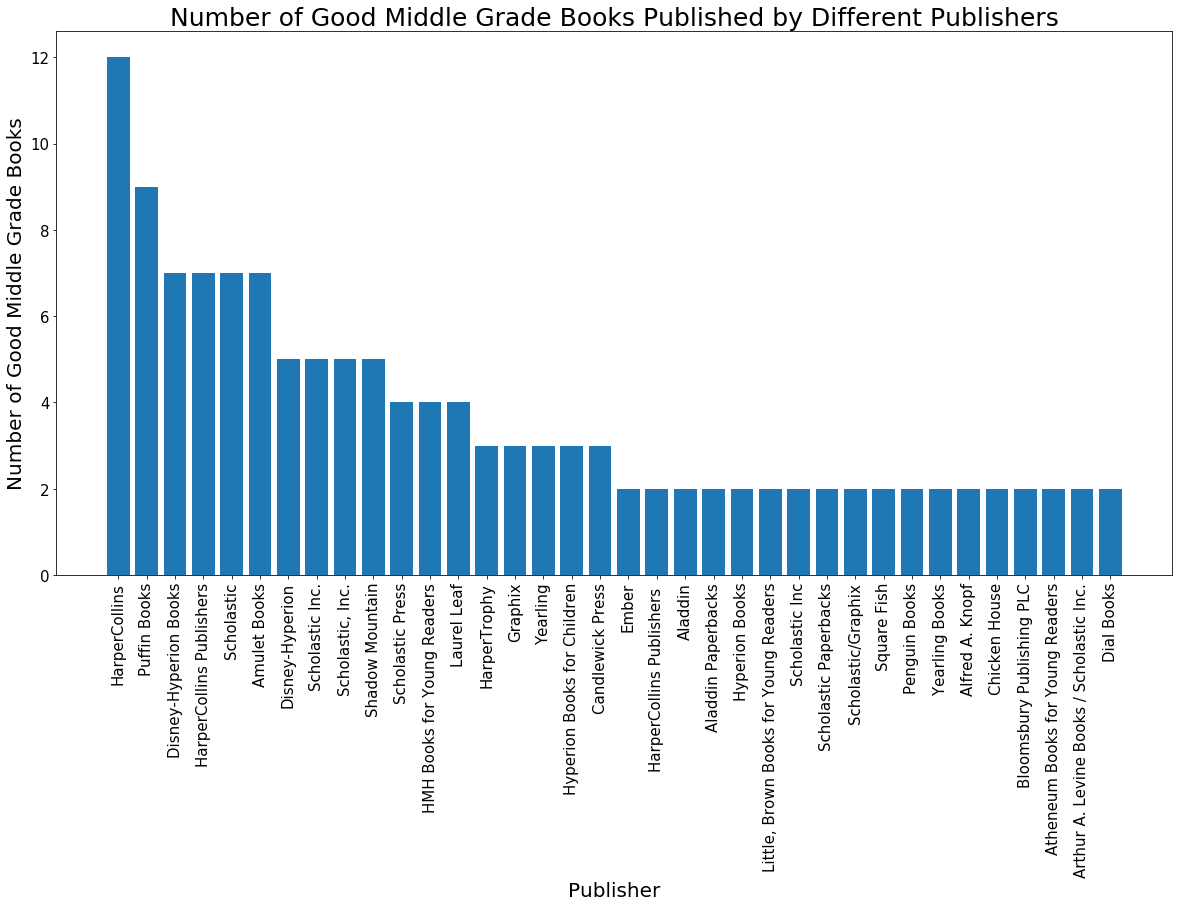

36


In [396]:
df = good_books.groupby("Publisher").size().to_frame(name="Book_cnt")
df = df.sort_values(by="Book_cnt", ascending=False)
df = df[df["Book_cnt"] >=2]

plt.figure(figsize=(20, 10)) 
plt.bar(x=df.index, height=df["Book_cnt"], width = 0.8)

plt.xticks(rotation='vertical', fontsize=15)
plt.yticks(fontsize = 15)
plt.xlabel("Publisher", fontsize=20)
plt.ylabel("Number of Good Middle Grade Books", fontsize=20)
plt.title("Number of Good Middle Grade Books Published by Different Publishers", fontsize=25)
plt.show()
print(len(df))

## Conclusions

J.K Rowling's Harry Potter Series are dominant winner of popular middle grade books with wide readers and good reviews. Another author Rick Riordan is an author I don't know before. But I will keep eyes on his works. 

The number of reveiw count is correlated with rating count. This is unsuprised.  

Next work is to see whether there is relationship between average rating and review count. Normally, better books should attrack more people to write review for them. 

Building a machine learning model to find similar books as my son's like. 
Extract review contents, find high frequency words, build a model based on it. Input the reviews of new books and find out similar one. 

Normalize the score by count of